In [ ]:
from google.colab import drive
drive.flush_and_unmount
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install kaggle

In [ ]:
import os
#from genericpath import exists
dataset_dir = '/content/drive/MyDrive/dataset/faces'

os.makedirs(dataset_dir, exist_ok=True)

os.chdir(dataset_dir)
print("Currently working: ", os.getcwd())

Currently working:  /content/drive/MyDrive/dataset/faces


In [ ]:
print(os.listdir(dataset_dir))

OSError: [Errno 5] Input/output error: '/content/drive/MyDrive/dataset/faces'

In [ ]:
len(os.listdir(dataset_dir))

LOADING AND PREPROCESSING DATA

In [ ]:
!pip install tensorflow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 74.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 105.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 97.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 109.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 5.5 MB/s eta 0:00:00


In [ ]:
#IMPORT LIBRARIES

import random
from PIL import Image
import numpy as np
import tensorflow as tf
from matplotlib.pylab import plt

import warnings
warnings.filterwarnings('ignore')

In [ ]:
#sset parameters of images
img_size = 64
buffer_size= 50000#shuffle image
batch_size = 200

DATA PREPROCESSING

In [ ]:

def load_and_preprocess_image(dataset_dir, imgsize):
  image = []#append preprocced data
  for subdir, _, files in os.walk(dataset_dir):#traverse
    for file in files:
      file_path = os.path.join(subdir, file)
      try:
        img = Image.open(file_path).convert('RGB')
        #resize
        img = img.resize((imgsize, imgsize))
        #float format
        img_array= np.array(img).astype('float32')
        #normalization
        img_array = (img_array-127.5)/127.5
        #aend
        image.append(img_array)
      except Exception as e:
        print(f"Error processing {file_path}: {e}")
  return np.array(image)

images_data = load_and_preprocess_image(dataset_dir, img_size)



In [ ]:
len(images_data)

52712

In [ ]:
images_data[0].shape#dimension of frist image(.shape for size)

(64, 64, 3)

In [ ]:
#BATCH AND SHUFFLE THE DATA

train_dataset = tf.data.Dataset.from_tensor_slices(images_data).shuffle(buffer_size).batch(batch_size)#changes to tensorflow dataset


In [ ]:
type(train_dataset)

tensorflow.python.data.ops.batch_op._BatchDataset

2. VISUALIZATION

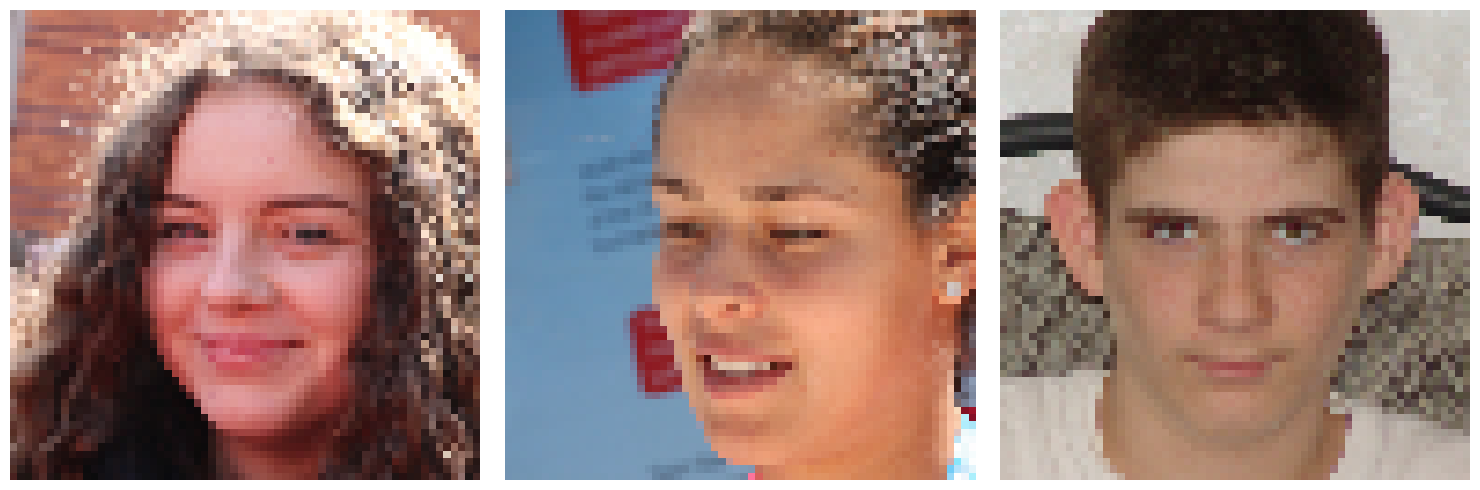

In [ ]:
img_files = os.listdir(dataset_dir)[:3]
#create a subplot

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, imgfile in enumerate(img_files):
  img_path = os.path.join(dataset_dir, imgfile)

  #oen image file
  img = Image.open(img_path)

  #display images
  axes[i].imshow(img)
  axes[i].axis('off')

plt.tight_layout()
#plt.show()


#3. CREATING MODELS

GENERATOR

In [ ]:
latent_dim = 100

def generator_model():
  model = tf.keras.Sequential([
      #dense layer of random nosie
      tf.keras.layers.Dense(8*8*512, input_dim = latent_dim, activation = 'relu'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Reshape((8, 8, 512)),#conveion to 1d to 3d

      #transpose convolution
      tf.keras.layers.Conv2DTranspose(filters = 256, kernel_size = (4,4), strides = (2, 2), padding = 'same', activation = 'relu'),
      tf.keras.layers.BatchNormalization(),

      tf.keras.layers.Conv2DTranspose(filters = 128, kernel_size = (4,4), strides = (2, 2), padding = 'same', activation = 'relu'),
      tf.keras.layers.BatchNormalization(),

      tf.keras.layers.Conv2DTranspose(filters = 64, kernel_size = (4, 4), strides = (2, 2), padding = 'same', activation = 'relu'),
      tf.keras.layers.BatchNormalization(),

      #otput
      tf.keras.layers.Conv2D(3, kernel_size = (4, 4), padding= 'same', activation= 'tanh')
  ])
  return model

generator = generator_model()
generator.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 32768)               │       3,309,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32768)               │         131,072 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 16, 16, 256)         │       2,097,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 16, 16, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 32, 32, 128)         │         524,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 64, 64, 64)          │         131,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 64, 64, 3)           │           3,075 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,198,467 (23.65 MB)

 Trainable params: 6,132,035 (23.39 MB)

 Non-trainable params: 66,432 (259.50 KB)

DISCRIMINATOR

In [ ]:
input = (64, 64, 3)

def discriminator():
  model = tf.keras.Sequential([
      tf.keras.layers.Conv2D(64, kernel_size = (4, 4), strides = (2, 2), padding = 'same', input_shape = input),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.LeakyReLU(alpha = 0.2),

      tf.keras.layers.Conv2D(128, kernel_size = (4, 4), strides = (2, 2), padding = 'same'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.LeakyReLU(alpha = 0.2),

      tf.keras.layers.Conv2D(256, kernel_size = (4, 4), strides = (2, 2), padding = 'same'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.LeakyReLU(alpha = 0.2),

      tf.keras.layers.Flatten(),
      tf.keras.layers.Dropout(0.3),

      tf.keras.layers.Dense(1, activation = 'sigmoid')
  ])
  return model

discriminator = discriminator()
discriminator.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 64)          │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 128)         │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 8, 8, 256)           │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 8, 8, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │          16,385 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 677,057 (2.58 MB)

 Trainable params: 676,161 (2.58 MB)

 Non-trainable params: 896 (3.50 KB)

#4. lOSS FUNCTIONS AND OPTIMIZERS

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)

DISCRIMINATOR LOSS

In [ ]:
def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

#GENERATOR LOSS

In [ ]:
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

##OPTIMIZERS

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate = (1e-4))
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate = (1e-4))

##5. DEFINING TRAINING LOOP

In [ ]:
epochs = 60
noise_dim = 100
num_examles_to_generate = 8
seed = tf.random.normal([num_examles_to_generate, noise_dim])

#TRAINING LOOP

In [ ]:
@tf.function
def train_step(images):
  noise = tf.random.normal([batch_size, noise_dim])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_image = generator(noise, training = True)

    real_output = discriminator(images, training =True)
    fake_output = discriminator(generated_image, training = True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

STORE GENERATED IMAGES

In [ ]:
def generate_and_save(model, epoch, test_input):
  predictions = model(test_input, training = False)
  predictions = (predictions+1)/2.0

  save_dir = "/content/drive/My Drive/generated_images"  # ✅ Directory to save images
  os.makedirs(save_dir, exist_ok=True)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow(predictions[i])
    plt.axis('off')

  plt.savefig('/content/drive/My Drive/generated_images/image_at_epoch_{:04d}.png'.format(epoch))
  plt.close()


In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    print(f"Starting epoch{epoch + 1}/{epochs}")

    for image_batch in dataset:
      train_step(image_batch)
    generate_and_save(generator, epoch + 1, seed)


In [ ]:
#train(train_dataset, epochs)

Starting epoch1/60


KeyboardInterrupt: 

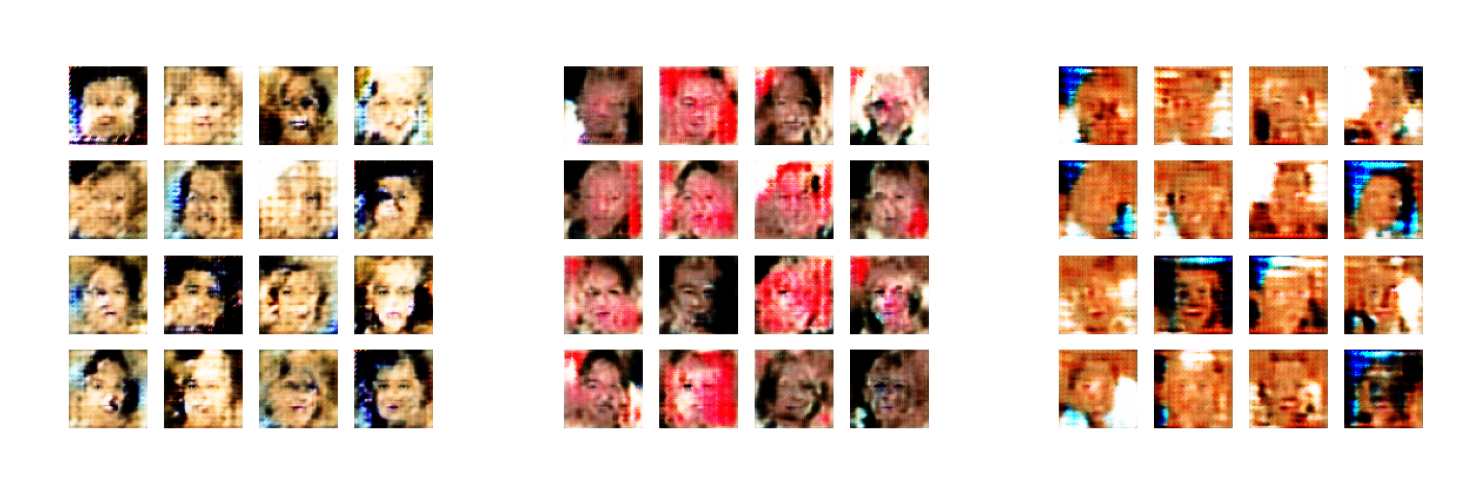

In [ ]:
image_folder = '/content/drive/My Drive/generated_images'
image_path = [os.path.join(image_folder, file) for file in os.listdir(image_folder) if file.endswith('.png')]
random_images = random.sample(image_path, 3)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax, img_path in zip(axes, random_images):
  img = Image.open(img_path)
  ax.imshow(img)
  ax.axis('off')

plt.tight_layout()


In [ ]:
!pip install imagehash


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.7/296.7 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 57.7 MB/s eta 0:00:00


In [ ]:
img = Image.open("/content/drive/My Drive/generated_images/image_at_epoch_0060.png").convert("RGB")
print(img.size)



(400, 400)


In [ ]:
import numpy as np
from PIL import Image

def detect_image_gaps_and_margins(image_path):
    img = Image.open(image_path).convert("L")  # convert to grayscale
    arr = np.array(img)

    # Threshold to treat nearly white as blank
    threshold = 250

    # Create a binary map: 1 if pixel is below threshold (i.e., not white), else 0
    binary = (arr < threshold).astype(np.uint8)

    # Sum along rows and columns to detect active areas
    vertical_profile = binary.sum(axis=1)  # horizontal lines
    horizontal_profile = binary.sum(axis=0)  # vertical lines

    # Detect top and bottom margins
    top_margin = np.argmax(vertical_profile > 0)
    bottom_margin = len(vertical_profile) - np.argmax(vertical_profile[::-1] > 0) - 1

    # Detect left and right margins
    left_margin = np.argmax(horizontal_profile > 0)
    right_margin = len(horizontal_profile) - np.argmax(horizontal_profile[::-1] > 0) - 1

    # Detect vertical gaps (between rows of tiles)
    vertical_gaps = []
    prev = top_margin
    for i in range(top_margin + 1, bottom_margin):
        if vertical_profile[i] == 0 and vertical_profile[i - 1] > 0:
            start = i
        if vertical_profile[i] > 0 and vertical_profile[i - 1] == 0:
            end = i
            gap = end - start
            vertical_gaps.append(gap)

    # Detect horizontal gaps (between columns of tiles)
    horizontal_gaps = []
    for i in range(left_margin + 1, right_margin):
        if horizontal_profile[i] == 0 and horizontal_profile[i - 1] > 0:
            start = i
        if horizontal_profile[i] > 0 and horizontal_profile[i - 1] == 0:
            end = i
            gap = end - start
            horizontal_gaps.append(gap)

    # Print results
    print(f"Top margin: {top_margin} pixels")
    print(f"Bottom margin: {img.height - bottom_margin - 1} pixels")
    print(f"Left margin: {left_margin} pixels")
    print(f"Right margin: {img.width - right_margin - 1} pixels")

    if vertical_gaps:
        print(f"Estimated vertical gap(s): {set(vertical_gaps)} pixels")
    else:
        print("No vertical gaps detected")

    if horizontal_gaps:
        print(f"Estimated horizontal gap(s): {set(horizontal_gaps)} pixels")
    else:
        print("No horizontal gaps detected")

# Example usage
detect_image_gaps_and_margins("/content/drive/My Drive/generated_images/image_at_epoch_0001.png")


Top margin: 48 pixels
Bottom margin: 44 pixels
Left margin: 50 pixels
Right margin: 40 pixels
Estimated vertical gap(s): {13, 14} pixels
Estimated horizontal gap(s): {14} pixels


In [ ]:
import os
from PIL import Image

# Paths
input_folder = "/content/drive/My Drive/generated_images"
output_base = "/content/drive/My Drive/split_tiles"

# Grid + layout config
grid_size = (4, 4)
tile_size = 64  # final size you want
# These were measured before:
left_margin = 50
top_margin = 48
right_margin = 40
bottom_margin = 44
horizontal_gap = 14
vertical_gap = 13

# Process all grid images
for filename in sorted(os.listdir(input_folder)):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
        print(f"Processing {filename}")
        img_path = os.path.join(input_folder, filename)
        img = Image.open(img_path).convert("RGB")

        # Create output folder for this image
        image_folder = os.path.join(output_base, filename.split('.')[0])
        os.makedirs(image_folder, exist_ok=True)

        # Split into tiles
        for row in range(grid_size[1]):
            for col in range(grid_size[0]):
                left = left_margin + col * ( (img.width - left_margin - right_margin - (grid_size[0]-1)*horizontal_gap) // grid_size[0] + horizontal_gap )
                upper = top_margin + row * ( (img.height - top_margin - bottom_margin - (grid_size[1]-1)*vertical_gap) // grid_size[1] + vertical_gap )
                right = left + ( (img.width - left_margin - right_margin - (grid_size[0]-1)*horizontal_gap) // grid_size[0] )
                lower = upper + ( (img.height - top_margin - bottom_margin - (grid_size[1]-1)*vertical_gap) // grid_size[1] )

                tile = img.crop((left, upper, right, lower)).resize((tile_size, tile_size))
                tile.save(os.path.join(image_folder, f"tile_{row * grid_size[0] + col}.png"))


Processing image_at_epoch_0001.png
Processing image_at_epoch_0002.png
Processing image_at_epoch_0003.png
Processing image_at_epoch_0004.png
Processing image_at_epoch_0005.png
Processing image_at_epoch_0006.png
Processing image_at_epoch_0007.png
Processing image_at_epoch_0008.png
Processing image_at_epoch_0009.png
Processing image_at_epoch_0010.png
Processing image_at_epoch_0011.png
Processing image_at_epoch_0012.png
Processing image_at_epoch_0013.png
Processing image_at_epoch_0014.png
Processing image_at_epoch_0015.png
Processing image_at_epoch_0016.png
Processing image_at_epoch_0017.png
Processing image_at_epoch_0018.png
Processing image_at_epoch_0019.png
Processing image_at_epoch_0020.png
Processing image_at_epoch_0021.png
Processing image_at_epoch_0022.png
Processing image_at_epoch_0023.png
Processing image_at_epoch_0024.png
Processing image_at_epoch_0025.png
Processing image_at_epoch_0026.png
Processing image_at_epoch_0027.png
Processing image_at_epoch_0028.png
Processing image_at_

In [ ]:
import os
from PIL import Image
import imagehash

# Paths
real_folder = "/content/drive/My Drive/orl_faces/faces"
generated_tiles_base = "/content/drive/My Drive/split_tiles"

# Similarity threshold
threshold = 5

# Load and hash real images
real_hashes = []
for filename in os.listdir(real_folder):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
        img = Image.open(os.path.join(real_folder, filename)).convert('RGB').resize((64, 64))
        img_hash = imagehash.phash(img)
        real_hashes.append((filename, img_hash))

print(f"Loaded and hashed {len(real_hashes)} real images.\n")

# Check each generated tile in each epoch folder
for epoch_folder in sorted(os.listdir(generated_tiles_base)):
    epoch_path = os.path.join(generated_tiles_base, epoch_folder)
    if not os.path.isdir(epoch_path):
        continue

    for tile_filename in sorted(os.listdir(epoch_path)):
        if tile_filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            tile_path = os.path.join(epoch_path, tile_filename)
            tile_img = Image.open(tile_path).convert('RGB').resize((64, 64))
            tile_hash = imagehash.phash(tile_img)

            match_found = False
            for real_filename, real_hash in real_hashes:
                distance = tile_hash - real_hash
                if distance <= threshold:
                    print(f"✅ SIMILAR (distance {distance}) → Epoch [{epoch_folder}], Tile [{tile_filename}] ≈ Real [{real_filename}]")
                    match_found = True
                    break

            if not match_found:
                print(f"❌ NO SIMILARITY → Epoch [{epoch_folder}], Tile [{tile_filename}]")


Loaded and hashed 10476 real images.

❌ NO SIMILARITY → Epoch [image_at_epoch_0001], Tile [tile_0.png]
❌ NO SIMILARITY → Epoch [image_at_epoch_0001], Tile [tile_1.png]
❌ NO SIMILARITY → Epoch [image_at_epoch_0001], Tile [tile_10.png]
❌ NO SIMILARITY → Epoch [image_at_epoch_0001], Tile [tile_11.png]
❌ NO SIMILARITY → Epoch [image_at_epoch_0001], Tile [tile_12.png]
❌ NO SIMILARITY → Epoch [image_at_epoch_0001], Tile [tile_13.png]
❌ NO SIMILARITY → Epoch [image_at_epoch_0001], Tile [tile_14.png]
❌ NO SIMILARITY → Epoch [image_at_epoch_0001], Tile [tile_15.png]
❌ NO SIMILARITY → Epoch [image_at_epoch_0001], Tile [tile_2.png]
❌ NO SIMILARITY → Epoch [image_at_epoch_0001], Tile [tile_3.png]
❌ NO SIMILARITY → Epoch [image_at_epoch_0001], Tile [tile_4.png]
❌ NO SIMILARITY → Epoch [image_at_epoch_0001], Tile [tile_5.png]
❌ NO SIMILARITY → Epoch [image_at_epoch_0001], Tile [tile_6.png]
❌ NO SIMILARITY → Epoch [image_at_epoch_0001], Tile [tile_7.png]
❌ NO SIMILARITY → Epoch [image_at_epoch_0001],

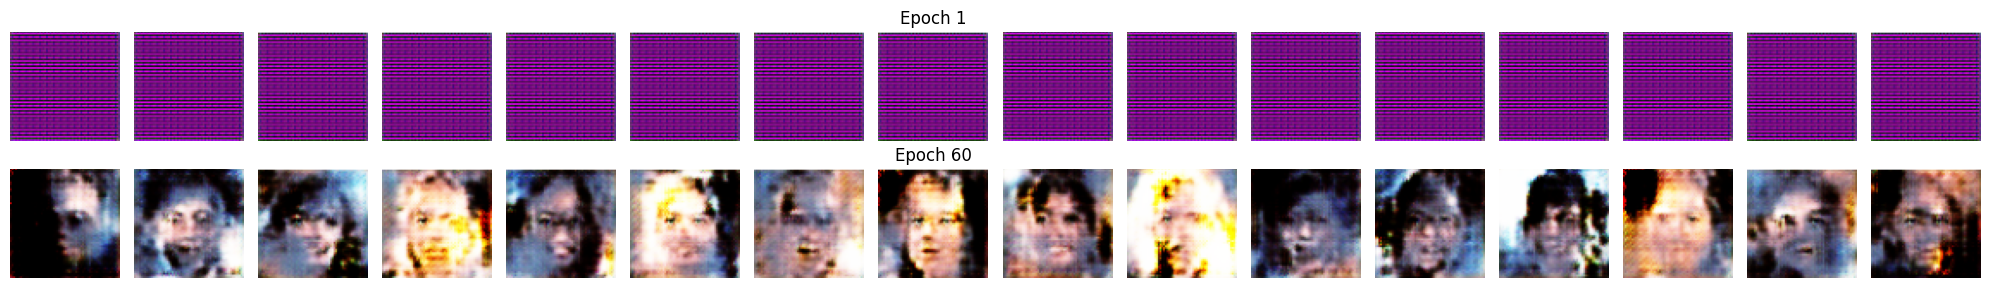

In [ ]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Paths to tile folders
tiles_root = "/content/drive/My Drive/split_tiles"
epoch1_dir = os.path.join(tiles_root, "image_at_epoch_0001")
epoch60_dir = os.path.join(tiles_root, "image_at_epoch_0060")

# Load up to 16 tiles from each epoch
epoch1_tiles = sorted([os.path.join(epoch1_dir, f) for f in os.listdir(epoch1_dir) if f.endswith('.png')])[:16]
epoch60_tiles = sorted([os.path.join(epoch60_dir, f) for f in os.listdir(epoch60_dir) if f.endswith('.png')])[:16]

# Display tiles in two rows (Epoch 1 and Epoch 60)
fig, axes = plt.subplots(2, 16, figsize=(20, 3))

for i in range(16):
    # Epoch 1
    img1 = Image.open(epoch1_tiles[i])
    axes[0, i].imshow(img1)
    axes[0, i].axis('off')
    if i == 7:
        axes[0, i].set_title("Epoch 1")

    # Epoch 60
    img60 = Image.open(epoch60_tiles[i])
    axes[1, i].imshow(img60)
    axes[1, i].axis('off')
    if i == 7:
        axes[1, i].set_title("Epoch 60")

plt.tight_layout()
plt.show()
